Name: Amrita Sinha Roy 
Student ID: 501306770

In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/wce_endoscopy_dataset/

/content/drive/MyDrive/wce_endoscopy_dataset


In [4]:
!unzip archive.zip

Archive:  archive.zip
replace test/0_normal/test_normal_ (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Simple CNN

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 3350s 32s/step - accuracy: 0.7328 - loss: 0.6762 - val_accuracy: 0.7390 - val_loss: 1.4280
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 484ms/step - accuracy: 0.9874 - loss: 0.0542 - val_accuracy: 0.7450 - val_loss: 1.7976
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 490ms/step - accuracy: 0.9926 - loss: 0.0294 - val_accuracy: 0.7450 - val_loss: 2.4038
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 493ms/step - accuracy: 0.9948 - loss: 0.0195 - val_accuracy: 0.6900 - val_loss: 3.0397
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 493ms/step - accuracy: 0.9892 - loss: 0.0421 - val_accuracy: 0.7285 - val_loss: 2.2680
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 509ms/step - accuracy: 0.9933 - loss: 0.0238 - val_accuracy: 0.7400 - val_loss: 4.3760
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 501ms/step - accuracy: 0.9948 - loss: 0.0122 - val_accuracy: 0.7415 - val_loss: 3.3103
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 492ms/step - accuracy: 0.9956 - loss: 0.0137 - val

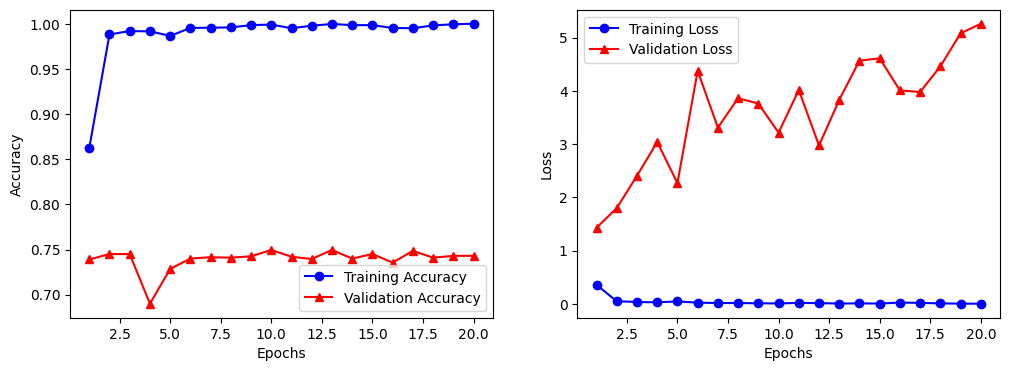

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Set directories for training, validation, and test sets
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Image and batch configuration
img_size = (128, 128)  # Resize images to 128x128
batch_size = 32

# Custom preprocessing function
def preprocess_image(image):
    # Convert to array, resize, and apply Gaussian blur
    image = cv2.resize(image, img_size)
    image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian blur with a 5x5 kernel
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Custom data generator with preprocessing
class CustomImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, img_size, shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.image_gen = ImageDataGenerator()  # Just to help with loading images and labels
        self.data_gen = self.image_gen.flow_from_directory(
            directory,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical'
        )
        self.on_epoch_end()

    def __len__(self):
        return len(self.data_gen)

    def __getitem__(self, index):
        batch_x, batch_y = self.data_gen[index]
        # Preprocess each image in the batch
        batch_x = np.array([preprocess_image(img) for img in batch_x])
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.data_gen.on_epoch_end()

# Load data with the custom generator
train_generator = CustomImageDataGenerator(train_dir, batch_size, img_size)
val_generator = CustomImageDataGenerator(val_dir, batch_size, img_size)
test_generator = CustomImageDataGenerator(test_dir, batch_size, img_size)

# Define a CNN model
def build_cnn_model(input_shape=(128, 128, 3), num_classes=4):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Instantiate and compile the CNN model
model = build_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Plot accuracy and loss over epochs
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'r^-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'r^-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [6]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_history(history, model_name="Model"):
    # Extract metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()




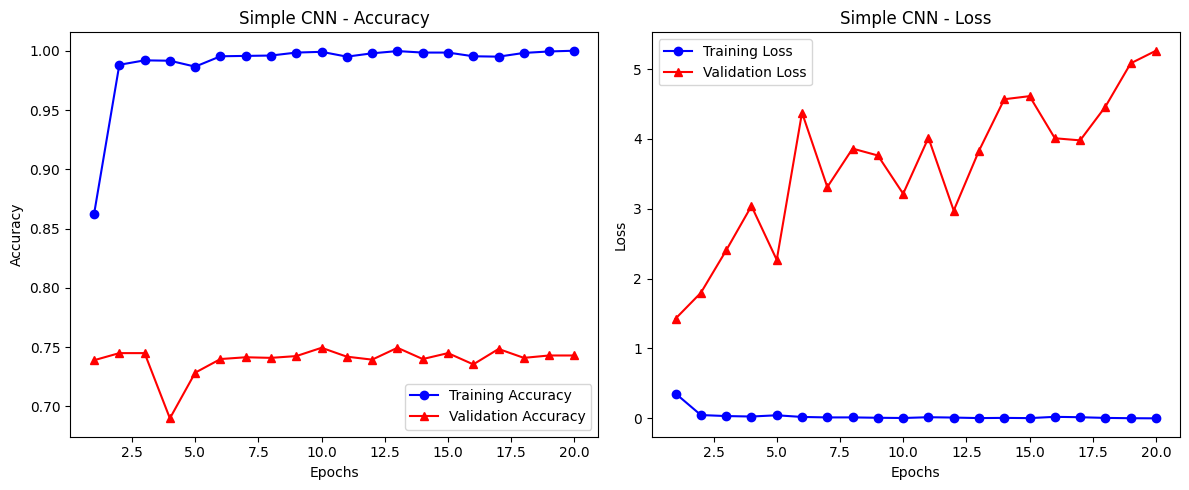

In [7]:
# Plotting for simple CNN
plot_history(history, model_name="Simple CNN")